In [2]:
import numpy as np
import pysal
import seaborn as sns
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
from utils.evaluation import plot_predictions,plot_histogram,calc_peak,calc_mean
from utils.metrics import calculate_crps
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


(16253, 10, 10)
(2000, 100, 100, 4)
[[0.00868992 0.00795411 0.0069081  ... 0.02926615 0.04666241 0.08763954]
 [0.00673808 0.00623223 0.00547102 ... 0.0333073  0.05354976 0.10181581]
 [0.00606399 0.00563639 0.00507211 ... 0.03352474 0.0531941  0.11126786]
 ...
 [0.01481331 0.01643911 0.02237002 ... 0.06595344 0.04559931 0.0390164 ]
 [0.01613863 0.01799718 0.02428336 ... 0.041515   0.02818449 0.02277585]
 [0.01603271 0.01791393 0.02442215 ... 0.03042007 0.02084375 0.01733673]]
show
85.6875
84.83486938476562
54.291782
39.0
40.7609977722168
22.374235
80.3125
51.406742095947266
26.52668
60.25
82.2154312133789
37.83138


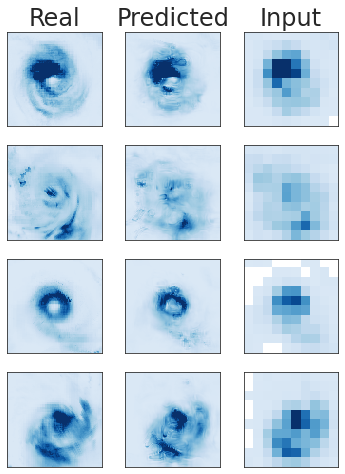

In [5]:
model = '_cat1_storms'
model = '_TS-0plus'
model = ''
# set mode
mode = 'validation'
mode = 'extreme_valid'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]
pred_ensemble = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# train_X = np.load('/user/work/al18709/tc_data_mswep/train_X.npy')
# train_y = np.load('/user/work/al18709/tc_data_mswep/train_y.npy')

print(pred_ensemble.shape)
print(pred[-1,:,:])
# real_train = np.load('/user/home/al18709/work/cgan_predictions/train_real.npy')[0][:,:,:,0]
# pred_train = np.load('/user/home/al18709/work/cgan_predictions/train_pred.npy')[0][:,:,:,0]
# inputs_train = np.load('/user/home/al18709/work/cgan_predictions/train_input.npy')[0][:,:,:,0]
plot_predictions(real,pred,inputs,plot='show',mode = mode)
# print(np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode)).shape)
# pred1 = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,1]
# plot_predictions(real,pred1,inputs,plot='show')
# pred2 = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,2]
# plot_predictions(real,pred2,inputs,plot='show')
# pred3 = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,3]
# plot_predictions(real,pred3,inputs,plot='show')

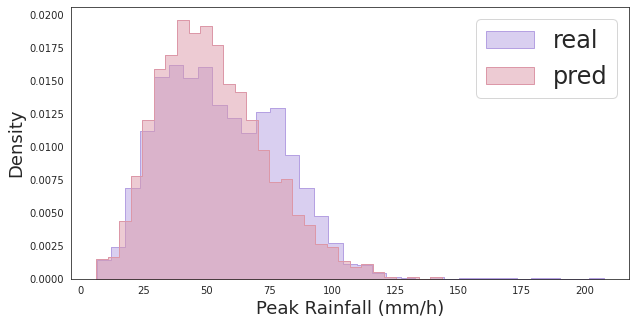

KstestResult(statistic=0.104, pvalue=7.793341222522051e-10)
KstestResult(statistic=0.104, pvalue=7.793341222522051e-10)


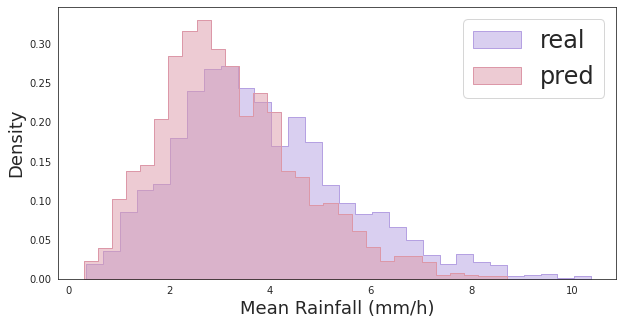

KstestResult(statistic=0.154, pvalue=4.212888961576606e-21)
KstestResult(statistic=0.0, pvalue=1.0)


In [6]:
# metric 1
# A standard metric to check how the distributions compare
# TODO: integrate ensemble predictions
# distributions
peak_reals = calc_peak(real)
peak_preds = calc_peak(pred)
plot_histogram(peak_reals,peak_preds,5,0.5,type = 'Peak')
ks = stats.kstest(peak_reals, peak_preds)
print(ks)
ks = stats.ks_2samp(peak_reals, peak_preds)
print(ks)

mean_reals = calc_mean(real)
mean_preds = calc_mean(pred)
plot_histogram(mean_reals,mean_preds,5,0.5)
ks = stats.kstest(mean_reals, mean_preds)
print(ks)
ks = stats.kstest(mean_preds,mean_preds)
print(ks)

# ks null hypothesis: two samples drawn from populations with the same distributions
# if p-value is small then you can reject the null hypothesis
# I think we want the p value to be large? or close to 1?

# TODO: could do the same thing for the 90th percentile or just the extreme validation set

In [7]:
# metric 2 
# common probabilistic forecasting score
# CRPS
crps = calculate_crps(real,pred_ensemble)
print(crps.shape)
print(np.mean(np.mean(crps,axis=1),axis=1))
print(np.mean(crps))

crps = ps.crps_ensemble(real,pred_ensemble)
print(crps.shape)
print(np.mean(np.mean(crps,axis=1),axis=1))
print(np.mean(crps))

(2000, 100, 100)
[1.0333179 1.1818377 1.3041056 ... 1.3144945 1.0406964 0.7611828]
1.0606204
(2000, 100, 100)
[1.03331785 1.18183771 1.30410561 ... 1.31449436 1.04069643 0.76118272]
1.0606206119555641


In [8]:
# metric 3
# standard sanity check, though not usually for stochastic models
# RMSE
nimages,_,_ = real.shape
RMSE = []
for i in range(nimages):
	rmse = sqrt(mean_squared_error(real[i], pred[i]))
	RMSE.append(rmse)

print(np.mean(RMSE))

2.8464596623159117


In [9]:
# metric 4
# metric to look specifically at spatial structure
# https://gis.stackexchange.com/questions/273785/morans-i-on-2d-arrays-rasters
# Spatial Correlation
# Moran's I - positive, negative autocorrelation - positive means similar values are clustered together and negative mean there's no spatial pattern
# https://journals.ametsoc.org/view/journals/mwre/136/6/2007mwr2255.1.xml
# https://d1wqtxts1xzle7.cloudfront.net/49336481/Probabilistic_rainfall_thresholds_for_fl20161004-25957-1lpf9s8-with-cover-page-v2.pdf?Expires=1646313112&Signature=A~uO2wqiCKdkqPu~QolyURBkRguxzw9P84Yfw8PrWYRkrOXMDyxAaxQmJafqcQOtr1FR68gWjq3MaLa2KFV3OwSvhB8douIzF4TJDXSPChkdwAh7p-Yc5A5WNPCFTMZkGJ-DyP60hZObnZUKs7y45FUcM9sWIbLfMgIuZXrW7vzf8vIXeQi-44LzV98XKYItKe7DAaTxyEWHGmWdFmlwKmBi~88P6rxAZd5xvNIsb4qzWNY~go-fKV~5oTcPQcF2VcsINGMjOkeywMxJQSm0cwHKpmS-ikhiXkBa5BrqsbwRQLNcJnbsWj-berQFW111h2ODWsAIAGp1AcF8qyuTdg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA


w = pysal.lat2W(real[0].shape[0],real[0].shape[1], rook=False, id_type="int")
mir = pysal.Moran(real[0], w, permutations = 9999)
lm = pysal.Moran_Local(real[0],w)
moran_significance = np.reshape(lm.p_sim, real[0].shape)
print(mir.I)
w = pysal.lat2W(pred[0].shape[0],pred[0].shape[1], rook=False, id_type="int")
mir = pysal.Moran(pred[0], w, permutations = 9999)
lm = pysal.Moran_Local(pred[0],w)
moran_significance = np.reshape(lm.p_sim, pred[0].shape)
print(mir.I)
# print(lm)
# print(moran_significance)

0.932834656505192
0.9570078685070769


In [36]:
# metric 6
# Accumulated Rainfall


In [ ]:
# metric 7 
# Similarity Score